In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

import numpy as np
from matplotlib import pyplot as plt

In [11]:
b=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512]))

In [18]:
b.trainable_variables

(<tf.Variable 'dense/kernel:0' shape=(2, 512) dtype=float32, numpy=
 array([[-0.09836753, -0.03695605,  0.05050795, ..., -0.08500519,
         -0.09642156, -0.08365773],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.        ,  0.        ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

In [13]:
sm = b.submodules[0]

In [17]:
sm.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2, 512) dtype=float32, numpy=
 array([[-0.09836753, -0.03695605,  0.05050795, ..., -0.08500519,
         -0.09642156, -0.08365773],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.        ,  0.        ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

In [15]:
b.forward(tf.constant([0., 1.]))

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

In [178]:
distr_real = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.7, 0.3]),
    components_distribution=tfd.Independent(tfd.Normal([[-2., -2], [2., 2.]], [[0.5], [0.5]]), reinterpreted_batch_ndims=1)
)
distr_real.batch_shape, distr_real.event_shape

(TensorShape([]), TensorShape([2]))

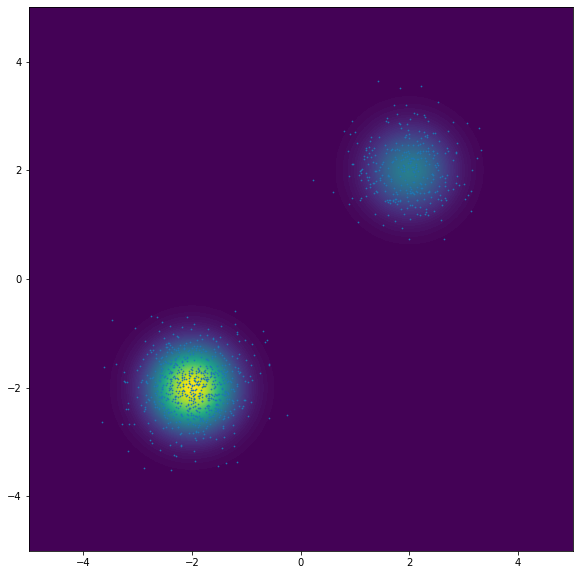

In [224]:
def plot_distr(distr):
    ax = plt.gca()
    ax.set_aspect("equal")
    XX, YY = np.mgrid[-5:5:100j, -5:5:100j]
    ZZ = distr.prob(np.stack([XX, YY], axis=-1))
    ax.contourf(XX, YY, ZZ, levels=100)
    ax.scatter(*distr.sample(1000).numpy().T, s=0.5)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    

fig, ax = plt.subplots(figsize=[10, 10])
plot_distr(distr_real)

In [180]:
distr_real.sample(1000).numpy().T.shape

(2, 1000)

In [181]:
distr_real.sample(1000)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 1.9308228 ,  1.9562783 ],
       [-2.816992  , -1.6935008 ],
       [ 0.92298234,  1.3178225 ],
       ...,
       [-1.0174832 , -1.8588985 ],
       [-3.0596209 , -2.2050145 ],
       [-1.9384451 , -2.0112636 ]], dtype=float32)>

In [182]:
num_bijectors = 5
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(
      shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
      hidden_layers=[512, 512])))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.


In [207]:
num_bijectors = 5
bijectors = []
for i in range(num_bijectors):
    b=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[32, 32]))
    bijectors.append(b)
    bijectors.append(tfb.Permute(permutation=[1, 0]))
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [208]:
distr0 = tfd.Independent(tfd.Normal([0., 0.], 1), reinterpreted_batch_ndims=1)
distr0.batch_shape, distr0.event_shape

(TensorShape([]), TensorShape([2]))

In [209]:
distr = tfd.TransformedDistribution(distr0, flow_bijector)

In [210]:
distr.sample()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.28651193, -1.2765124 ], dtype=float32)>

In [211]:
trainable_weights = flow_bijector.trainable_variables
len(trainable_weights)

30

In [212]:
sample = distr_real.sample(10000)

In [213]:
optimizer = tf.optimizers.Adam(learning_rate=0.00001)

In [214]:
def get_loss():
    nll = - tf.reduce_sum(distr.log_prob(sample))
    return nll

get_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=9111078.0>

In [236]:
# ideal loss
- tf.reduce_sum(distr_real.log_prob(sample))

<tf.Tensor: shape=(), dtype=float32, numpy=20731.828>

In [215]:
distr.log_prob([0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=-1.837877>

In [216]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = get_loss()
        
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return loss

In [218]:
train_step()

<tf.Tensor: shape=(), dtype=float32, numpy=8851901.0>

In [170]:
%timeit train_step()

20.8 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [239]:
history = []

for i in range(1000000):
    loss = train_step()
    history.append(loss)
    if i % 100 == 0:
        print(i, loss)

0 tf.Tensor(25991.902, shape=(), dtype=float32)
100 tf.Tensor(25991.68, shape=(), dtype=float32)
200 tf.Tensor(25991.508, shape=(), dtype=float32)
300 tf.Tensor(25991.324, shape=(), dtype=float32)
400 tf.Tensor(25991.184, shape=(), dtype=float32)
500 tf.Tensor(25990.963, shape=(), dtype=float32)
600 tf.Tensor(25990.781, shape=(), dtype=float32)
700 tf.Tensor(25990.605, shape=(), dtype=float32)
800 tf.Tensor(25990.428, shape=(), dtype=float32)
900 tf.Tensor(25990.246, shape=(), dtype=float32)
1000 tf.Tensor(25990.068, shape=(), dtype=float32)
1100 tf.Tensor(25989.912, shape=(), dtype=float32)
1200 tf.Tensor(25989.709, shape=(), dtype=float32)
1300 tf.Tensor(25989.527, shape=(), dtype=float32)
1400 tf.Tensor(25989.35, shape=(), dtype=float32)
1500 tf.Tensor(25989.174, shape=(), dtype=float32)
1600 tf.Tensor(25989.014, shape=(), dtype=float32)
1700 tf.Tensor(25988.814, shape=(), dtype=float32)
1800 tf.Tensor(25988.633, shape=(), dtype=float32)
1900 tf.Tensor(25988.732, shape=(), dtype=flo

KeyboardInterrupt: 

In [240]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=25978.004>

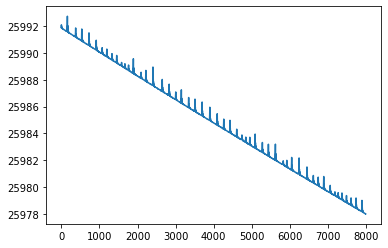

In [241]:
plt.plot(history)

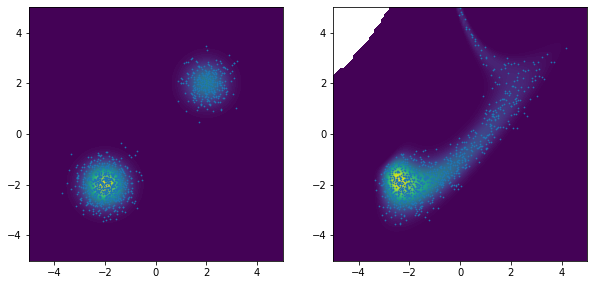

In [242]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
plt.sca(axs[0])
plot_distr(distr_real)
plt.sca(axs[1])
plot_distr(distr)